In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, gzip
import matplotlib.pyplot as plt
import pysam

import sys

sys.path.append("../../../src/")
import lakeview as lv

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 100

In [3]:
%matplotlib widget
plt.ioff()

In [4]:
CHROMOSOME = "chr14"
START = 104586347
END = 107043718
REGION = f"{CHROMOSOME}:{START}-{END}"
PACBIO_BAM_URL = "ftp://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/data/AshkenazimTrio/HG002_NA24385_son/PacBio_CCS_15kb_20kb_chemistry2/GRCh38/HG002.SequelII.merged_15kb_20kb.pbmm2.GRCh38.haplotag.10x.bam"
PACBIO_BAI_URL = "ftp://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/data/AshkenazimTrio/HG002_NA24385_son/PacBio_CCS_15kb_20kb_chemistry2/GRCh38/HG002.SequelII.merged_15kb_20kb.pbmm2.GRCh38.haplotag.10x.bam.bai"
PACBIO_BAM_PATH = "data/PacBio_CCS.bam"
PACBIO_BAI_PATH = "data/PacBio_CCS.bam.bai"


PACBIO_BAM_URL = "ftp://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/data/AshkenazimTrio/HG002_NA24385_son/PacBio_CCS_15kb/GRCh38_no_alt_analysis/HG002.15kb.Sequel.pbmm2.GRCh38.whatshap.haplotag.RTG.10x.trio.bam"
PACBIO_BAI_URL = "ftp://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/data/AshkenazimTrio/HG002_NA24385_son/PacBio_CCS_15kb/GRCh38_no_alt_analysis/HG002.15kb.Sequel.pbmm2.GRCh38.whatshap.haplotag.RTG.10x.trio.bam.bai"

if not os.path.isfile(PACBIO_BAM_PATH):
    bam_data = pysam.view(
        "-X",
        "-b",
        PACBIO_BAM_URL,
        PACBIO_BAI_URL,
        REGION,
    )
    with open(PACBIO_BAM_PATH, "wb") as f:
        f.write(bam_data)
if not os.path.isfile(PACBIO_BAI_PATH):
    pysam.index(PACBIO_BAM_PATH)

In [5]:
pacbio_painter = lv.SequenceAlignment.from_file(PACBIO_BAM_PATH, "rb")

In [6]:
with gzip.open("data/gencode.v40.annotation.gtf.gz", "rt") as f:
    gencode_painter = lv.GeneAnnotation.from_file(
        file_handle=f,
        format="gtf",
        sequence_name=CHROMOSOME,
        start=START,
        end=END,
    )
gencode_painter.transcripts.sort(key=len, reverse=True)

In [7]:
gv = lv.GenomeViewer(3, height_ratios=(1, 8, 2))
pacbio_painter.draw_pileup(
    gv.axes[0],
    show_mismatches=False,
)
pacbio_painter.draw_alignment(
    gv.axes[1],
    show_mismatches=False,
    order=lambda seg: -seg.query_alignment_length,
    max_depth=50,
)
gencode_painter.draw_transcripts(gv.axes[2], max_group_depth=4, labels=lambda t: t.id)

gv.set_xlim((105679000, 105776000))

In [11]:
gv

AppLayout(children=(VBox(children=(HBox(children=(Text(value='105,679,000 - 105,776,000', placeholder=''), But…

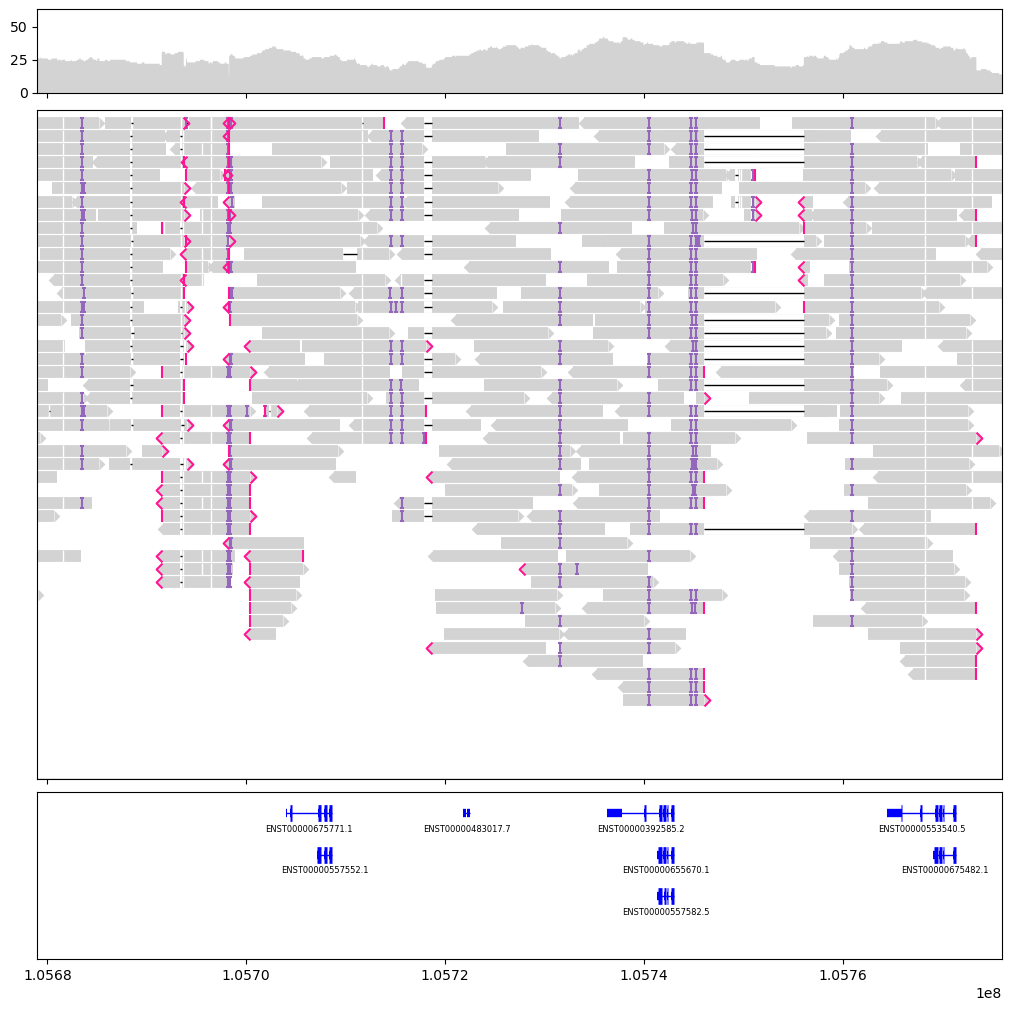

In [9]:
gv.figure

In [10]:
gv.savefig("figures/HG002_IGH.png", dpi=300)